## Adding Class Activation Mapping to Spectograms

This script contains a notebook that demonstrates the process of adding Class Activation Mapping (CAM) to spectrograms. The purpose of CAM is to provide visual explanations of which regions in the image were pivotal in making a prediction, making it an essential tool for model interpretability., this code is a modification of the code found on Kaggle.

- Link to Kaggle code : https://www.kaggle.com/code/guglielmocamporese/what-is-my-model-seeing-class-activation-mapping

The Spectograms are from audio files belong to three species:

- Charadrius ruficapillus (Red-capped plover)
- Chenonetta jubata (Australian Wood Duck)
- Chlamydera nuchalis (Great bowerbird)

This data was sourced from Project Echo bucket 2

In [2]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torch.nn.functional as F
import numpy as np
import skimage.transform
from IPython.display import display, Audio

In [3]:
# Displaying the files to be played

# Specify the path to your folder containing audio files
audio_folder_path = "/content/Audios"

# Iterate over all files in the folder
for audio_file in os.listdir(audio_folder_path):
    if audio_file.endswith(('.wav', '.mp3')):
        display(Audio(os.path.join(audio_folder_path, audio_file)))

In [4]:
image_folder_path = "/content/Images"

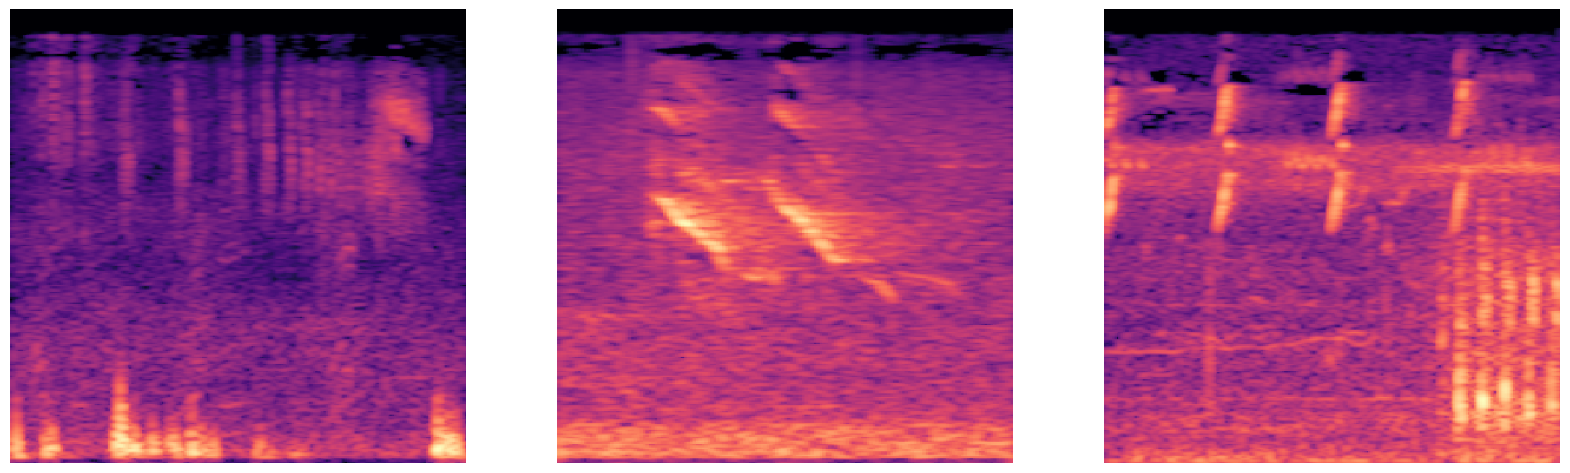

In [5]:
image_list = []
for image_file in os.listdir(image_folder_path):
    if image_file.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(image_folder_path, image_file)
        image = Image.open(image_path).convert('RGB')
        image_list.append(image)

# Ensure there are at least three images as the code is designed for a 1x3 grid of subplots (axes)
if len(image_list) < 3:
    raise ValueError("Please ensure the folder contains at least three image files.")

# 3. Display the images in a 1x3 grid using Matplotlib
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
for ax, img in zip(axes, image_list[:3]):
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [12]:
# Data Preprocessing
# Imagenet mean/std
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.ToTensor(),
   normalize,
])

images = [Image.open(os.path.join(image_folder_path, image_file)).convert('RGB') for image_file in os.listdir(image_folder_path) if image_file.endswith(('.png', '.jpg', '.jpeg'))]
preprocessed_images = [preprocess(img).unsqueeze(0) for img in images]

In [13]:
# Loading the pretrained model

model = models.resnet18(weights=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Get the features from a model

class SaveFeatures():
    features = None
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output.data.cpu().numpy()

    def remove(self):
        self.hook.remove()

def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h * w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [15]:
# Get features from last conv layer
final_layer = model._modules.get('layer4')

# Initialize the SaveFeatures class for the final_layer
activated_features = SaveFeatures(final_layer)

# Store results
predictions = []
pred_probs = []
cams = []

# Iterate over preprocessed images
for x_img in preprocessed_images:

    # Inference
    model.eval()
    prediction = model(x_img)
    pred_probabilities = F.softmax(prediction, dim=1).data.squeeze()

    # Store results
    predictions.append(torch.topk(pred_probabilities, 1))
    pred_probs.append(pred_probabilities)

    # Take weights from the first linear layer
    weight_softmax_params = list(model._modules.get('fc').parameters())
    weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

    # Get the top-1 prediction and get CAM
    class_idx = torch.topk(pred_probabilities, 1)[1].int()
    overlay = getCAM(activated_features.features, weight_softmax, class_idx)

    cams.append(overlay)

# Cleanup
activated_features.remove()

# Print results (for demonstration purposes)
for pred in predictions:
    print('Top-1 prediction:', pred)


Top-1 prediction: torch.return_types.topk(
values=tensor([0.1207]),
indices=tensor([483]))
Top-1 prediction: torch.return_types.topk(
values=tensor([0.0879]),
indices=tensor([472]))
Top-1 prediction: torch.return_types.topk(
values=tensor([0.3103]),
indices=tensor([530]))


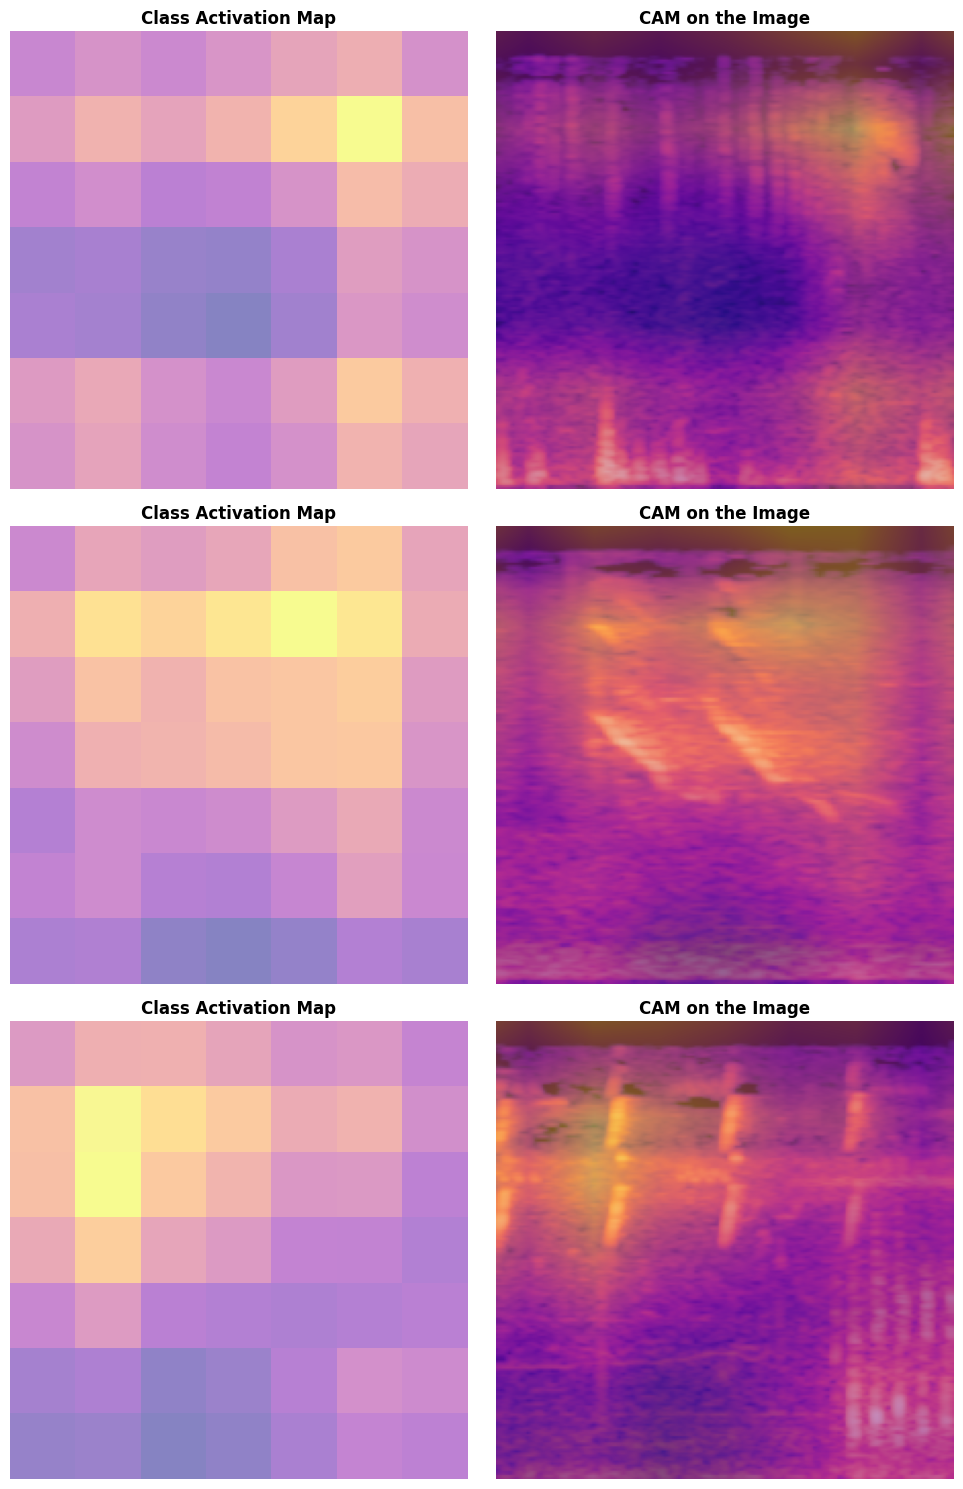

In [17]:
# Displaying CAMS and overlay

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):
    # Display CAM
    axes[i, 0].set_title('Class Activation Map', fontweight='bold')
    axes[i, 0].imshow(cams[i][0], alpha=0.5, cmap='plasma')
    axes[i, 0].axis("off")

    # Convert tensor to numpy and adjust dimensions
    img_np = preprocessed_images[i].squeeze().permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize to [0,1]

    # Display CAM on the image
    axes[i, 1].set_title('CAM on the Image', fontweight='bold')
    axes[i, 1].imshow(img_np)
    axes[i, 1].imshow(skimage.transform.resize(cams[i][0], img_np.shape[:2]), alpha=0.5, cmap='plasma')
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()